Make sure to open in Colab to see the plots!

In [31]:
from scipy.integrate import odeint
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline 
!pip install mpld3
import mpld3
mpld3.enable_notebook()

You are using pip version 9.0.1, however version 20.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [32]:
def plotseird(t, S, E, I, R, D=None, L=None, R0=None, Alpha=None, CFR=None):
  f, ax = plt.subplots(1,1,figsize=(10,4))
  ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
  ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
  ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
  ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
  if D is not None:
    ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    ax.plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')
  else:
    ax.plot(t, S+E+I+R, 'c--', alpha=0.7, linewidth=2, label='Total')

  ax.set_xlabel('Time (days)')

  ax.yaxis.set_tick_params(length=0)
  ax.xaxis.set_tick_params(length=0)
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')
  legend = ax.legend(borderpad=2.0)
  legend.get_frame().set_alpha(0.5)
  for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)
  if L is not None:
      plt.title("Lockdown after {} days".format(L))
  plt.show();

  if R0 is not None or CFR is not None:
    f = plt.figure(figsize=(12,4))
  
  if R0 is not None:
    # sp1
    ax1 = f.add_subplot(121)
    ax1.plot(t, R0, 'b--', alpha=0.7, linewidth=2, label='R_0')

    ax1.set_xlabel('Time (days)')
    ax1.title.set_text('R_0 over time')
    # ax.set_ylabel('Number (1000s)')
    # ax.set_ylim(0,1.2)
    ax1.yaxis.set_tick_params(length=0)
    ax1.xaxis.set_tick_params(length=0)
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)

  if Alpha is not None:
    # sp2
    ax2 = f.add_subplot(122)
    ax2.plot(t, Alpha, 'r--', alpha=0.7, linewidth=2, label='alpha')

    ax2.set_xlabel('Time (days)')
    ax2.title.set_text('fatality rate over time')
    # ax.set_ylabel('Number (1000s)')
    # ax.set_ylim(0,1.2)
    ax2.yaxis.set_tick_params(length=0)
    ax2.xaxis.set_tick_params(length=0)
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)

    plt.show();

## Programming the Exposed-Compartment

In [33]:
def deriv(y, t, N, beta, gamma, delta):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - gamma * I
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

In [168]:
N = 528
D = 10.0 # infections lasts ten days
gamma = 1.0 / D
delta = 1.0 / 5.5 # incubation period of five.five days
R_0 = 3
beta = R_0 * gamma  # R_0 = beta / gamma, so beta = R_0 * gamma
S0, E0, I0, R0 = N-1, 0, 1, 0  # initial conditions: one exposed

In [158]:
t = np.linspace(0, 100, 100) # Grid of time points (in days)
y0 = S0, E0, I0, R0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta))
S, E, I, R = ret.T

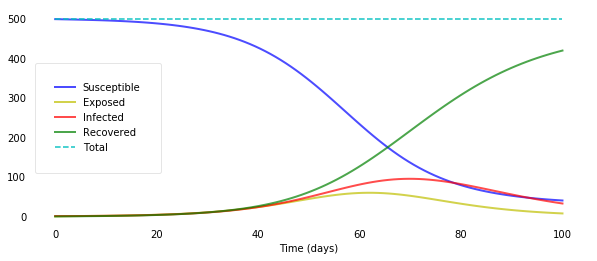

In [148]:
plotseird(t, S, E, I, R)

In [37]:
# get the real data
# fit the curve
data = pd.read_csv('SEIR_data.csv')
data.head()

,Date,S,E,I,R,Incidence
0,13/03/2020,528,0,0,0,0
1,14/03/2020,527,1,0,0,0
2,15/03/2020,527,1,0,0,0
3,16/03/2020,527,1,0,0,0
4,17/03/2020,527,1,0,0,0


In [169]:
def fit_odeint(x, beta, gamma,delta):
    return odeint(deriv, y0, x, args=(N, beta, gamma, delta))[:,2]

In [177]:
def optimize_sliced_data(x,y):
# Do the sampling 100 times to get the error estimates 
    popt, pcov = optimize.curve_fit(fit_odeint, x, y)
    fitted = fit_odeint(x, *popt)
    return popt, pcov
def show_parameters(popt, pcov):
    print(f'beta:- {popt[0]}')
    print(f'gamma:- {popt[1]}')
    print(f'delta:- {popt[2]}')
    perr = np.sqrt(np.diag(pcov))
    print('Covariance Matrix', pcov)
    print('Error estimates', perr)
    #print(type(popt))
    R0 = popt[0]/popt[1]
    print("R0 value : %2.4f" %(R0) )
    return popt[0], popt[1],perr, pcov, R0 

In [201]:
x = [i for i in range(0,data.shape[0])]
y = np.asarray(data['I'])


In [200]:
x1  = x[0:20]
y1 = y[0:20]

popt1, pcov1 =  optimize_sliced_data(x1,y1)
beta1,gamma1, errors1,cov1, R01 = show_parameters(popt, pcov) 


beta:- 5.942151738491805
gamma:- 3.7728141627841882
delta:- 0.30841545598572084
Covariance Matrix [[ 2849.05112132   281.74896849  -205.47637184]
 [  281.74896849    29.08251013   -20.12455715]
 [ -205.47637184   -20.12455715    14.85181641]]
Error estimates [ 53.37650346   5.39282024   3.85380544]
R0 value : 1.5750


In [183]:
x2  = x[20:]
y2 = y[20:]

popt2, pcov2 =  optimize_sliced_data(x2,y2)
beta2,gamma2, errors2,cov2, R02 = show_parameters(popt2, pcov2) 

beta:- 3.6008400707996064
gamma:- 4.823777413109695
delta:- 24.384456970606923
Covariance Matrix [[  0.10944645   0.14076461  -1.42559648]
 [  0.14076461   0.18661415  -1.71811196]
 [ -1.42559648  -1.71811196  63.30970562]]
Error estimates [ 0.33082691  0.43198859  7.95673964]
R0 value : 0.7465


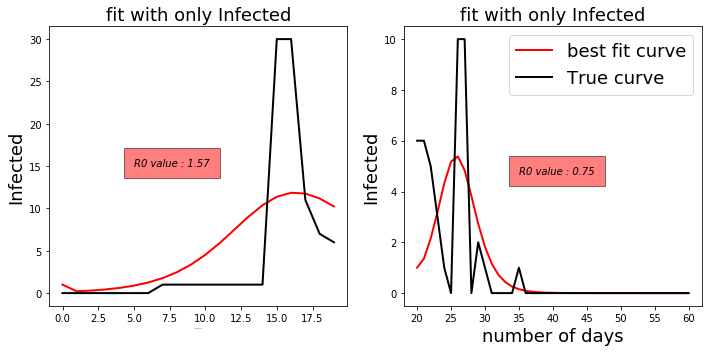

In [199]:
#print(fitted)
#plt.plot(x, y, '-')
#plt.plot(x, fitted, '-')
#plt.show()

# prepare confidence level curves
#nstd = 1.0 # to draw 5-sigma intervals
#popt_up = popt + nstd*perr
#popt_dw = popt – nstd*perr
#popt_dw= popt-nstd*perr
fit1 = fit_odeint(x1, *popt1)
fit2= fit_odeint(x2, *popt2)
#fit_up = fit_odeint(x, *popt_up)
#fit_dw = fit_odeint(x, *popt_dw)
#print(fit_dw)
#print(fit_up)
#plot
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (10, 5))

ax1.set_xlabel('number of days', fontsize=18)
ax1.set_ylabel('Infected', fontsize=18)
ax1.set_title('fit with only Infected' , fontsize=18)
ax1.plot(x1, fit1, 'r', lw=2, label='best fit curve')
ax1.plot(x1, y1, 'k-', lw=2, label='True curve')
#plt.plot(x,y,'k-', lw=2)
#ax.fill_between(x,fit_up, fit_dw, alpha = 0.25)
#ax.fill_between(x, fit_up, fit_dw, alpha=.25, label='5-sigma interval')

ax1.text(5, 15, 'R0 value : %2.2f' %(R01) , style='italic',
       bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})

ax2.set_xlabel('number of days', fontsize=18)
ax2.set_ylabel('Infected', fontsize=18)
ax2.set_title('fit with only Infected' , fontsize=18)
ax2.plot(x2, fit2, 'r', lw=2, label='best fit curve')
ax2.plot(x2, y2, 'k-', lw=2, label='True curve')
#plt.plot(x,y,'k-', lw=2)
#ax.fill_between(x,fit_up, fit_dw, alpha = 0.25)
#ax.fill_between(x, fit_up, fit_dw, alpha=.25, label='5-sigma interval')

ax2.legend(loc='upper right',fontsize=18)
ax2.text(35, 4.7, 'R0 value : %2.2f' %(R02) , style='italic',
       bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
plt.tight_layout()
plt.show()

In [203]:
# take all the data
popt, pcov =  optimize_sliced_data(x,y)
beta,gamma, errors,cov, R0 = show_parameters(popt, pcov) 


beta:- 5.858996621597072
gamma:- 4.194808599788786
delta:- 0.39228777608480736
Covariance Matrix [[ 67.85707775  16.60343047  -5.26279435]
 [ 16.60343047   4.17938343  -1.26938397]
 [ -5.26279435  -1.26938397   0.41164909]]
Error estimates [ 8.23754076  2.04435404  0.64159885]
R0 value : 1.3967


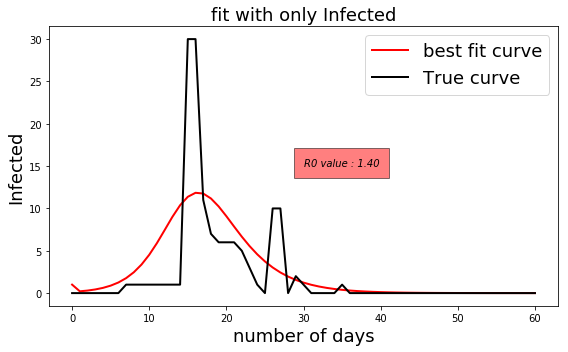

In [208]:
fit = fit_odeint(x, *popt)
#fit_up = fit_odeint(x, *popt_up)
#fit_dw = fit_odeint(x, *popt_dw)
#print(fit_dw)
#print(fit_up)
#plot
fig, (ax1) = plt.subplots(1,1, figsize = (8, 5))

ax1.set_xlabel('number of days', fontsize=18)
ax1.set_ylabel('Infected', fontsize=18)
ax1.set_title('fit with only Infected' , fontsize=18)
ax1.plot(x, fit, 'r', lw=2, label='best fit curve')
ax1.plot(x, y, 'k-', lw=2, label='True curve')
#plt.plot(x,y,'k-', lw=2)
#ax.fill_between(x,fit_up, fit_dw, alpha = 0.25)
#ax.fill_between(x, fit_up, fit_dw, alpha=.25, label='5-sigma interval')

ax1.text(30, 15, 'R0 value : %2.2f' %(R0) , style='italic',
       bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})



ax1.legend(loc='upper right',fontsize=18)
plt.tight_layout()
plt.show()

## Programming the Dead-Compartment

In [12]:
def deriv(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

In [13]:
N = 1_000_000
D = 4.0 # infections lasts four days
gamma = 1.0 / D
delta = 1.0 / 5.0  # incubation period of five days
R_0 = 5.0
beta = R_0 * gamma  # R_0 = beta / gamma, so beta = R_0 * gamma
alpha = 0.2  # 20% death rate
rho = 1/9  # 9 days from infection until death
S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  # initial conditions: one exposed

In [14]:
t = np.linspace(0, 99, 100) # Grid of time points (in days)
y0 = S0, E0, I0, R0, D0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho))
S, E, I, R, D = ret.T

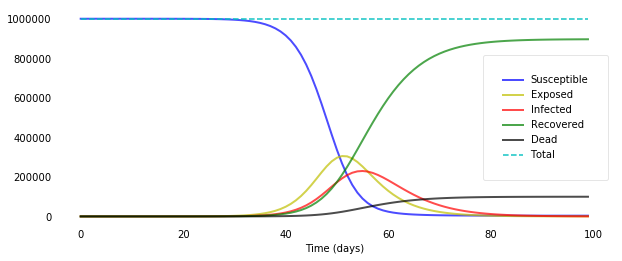

In [15]:
plotseird(t, S, E, I, R, D)

## Time-Dependent $R_{0}$

### Simple Approach: Single Lockdown

In [16]:
def deriv(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y
    dSdt = -beta(t) * S * I / N
    dEdt = beta(t) * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

In [17]:
L = 40

In [18]:
N = 1_000_000
D = 4.0 # infections lasts four days
gamma = 1.0 / D
delta = 1.0 / 5.0  # incubation period of five days
def R_0(t):
    return 5.0 if t < L else 0.9
def beta(t):
    return R_0(t) * gamma

alpha = 0.2  # 20% death rate
rho = 1/9  # 9 days from infection until death
S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  # initial conditions: one exposed

In [19]:
t = np.linspace(0, 99, 100) # Grid of time points (in days)
y0 = S0, E0, I0, R0, D0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho))
S, E, I, R, D = ret.T

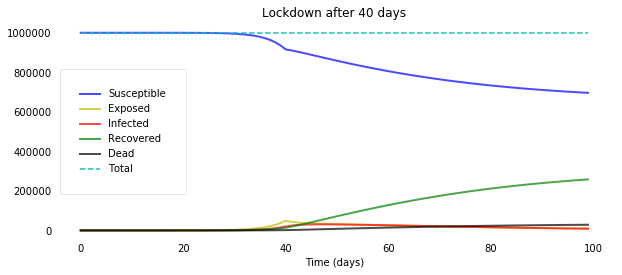

In [20]:
plotseird(t, S, E, I, R, D, L)

### Advanced Approach: logistic $R_{0}$

In [21]:
def deriv(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y
    dSdt = -beta(t) * S * I / N
    dEdt = beta(t) * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

In [22]:
N = 1_000_000
D = 4.0 # infections lasts four days
gamma = 1.0 / D
delta = 1.0 / 5.0  # incubation period of five days

R_0_start, k, x0, R_0_end = 5.0, 0.5, 50, 0.5

def logistic_R_0(t):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def beta(t):
    return logistic_R_0(t) * gamma

alpha = 0.2  # 20% death rate
rho = 1/9  # 9 days from infection until death
S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  # initial conditions: one exposed

In [23]:
t = np.linspace(0, 99, 100) # Grid of time points (in days)
y0 = S0, E0, I0, R0, D0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho))
S, E, I, R, D = ret.T
R0_over_time = [logistic_R_0(i) for i in range(len(t))]  # to plot R_0 over time: get function values

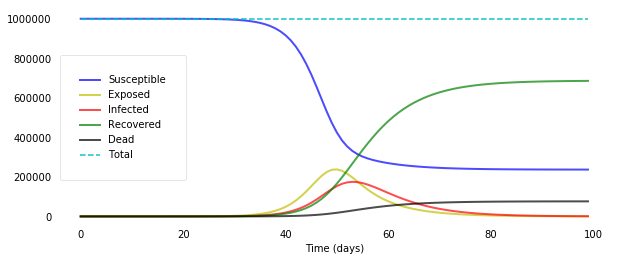

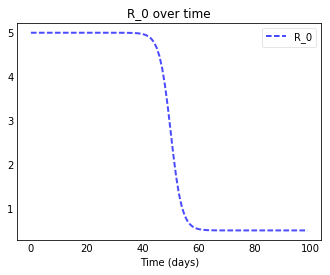

In [24]:
plotseird(t, S, E, I, R, D, R0=R0_over_time)

### Resource- and Age-Dependent Fatality Rate

In [25]:
def deriv(y, t, N, beta, gamma, delta, alpha_opt, rho):
    S, E, I, R, D = y
    def alpha(t):
        return s * I/N + alpha_opt

    dSdt = -beta(t) * S * I / N
    dEdt = beta(t) * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha(t)) * gamma * I - alpha(t) * rho * I
    dRdt = (1 - alpha(t)) * gamma * I
    dDdt = alpha(t) * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

In [26]:
N = 1_000_000
D = 4.0 # infections lasts four days
gamma = 1.0 / D
delta = 1.0 / 5.0  # incubation period of five days

R_0_start, k, x0, R_0_end = 5.0, 0.5, 50, 0.5

def logistic_R_0(t):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def beta(t):
    return logistic_R_0(t) * gamma

alpha_by_agegroup = {"0-29": 0.01, "30-59": 0.05, "60-89": 0.2, "89+": 0.3}
proportion_of_agegroup = {"0-29": 0.1, "30-59": 0.3, "60-89": 0.4, "89+": 0.2}
s = 0.01
alpha_opt = sum(alpha_by_agegroup[i] * proportion_of_agegroup[i] for i in list(alpha_by_agegroup.keys()))

rho = 1/9  # 9 days from infection until death
S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  # initial conditions: one exposed

In [27]:
t = np.linspace(0, 99, 100) # Grid of time points (in days)
y0 = S0, E0, I0, R0, D0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha_opt, rho))
S, E, I, R, D = ret.T
R0_over_time = [logistic_R_0(i) for i in range(len(t))]  # to plot R_0 over time: get function values
Alpha_over_time = [s * I[i]/N + alpha_opt for i in range(len(t))]  # to plot alpha over time

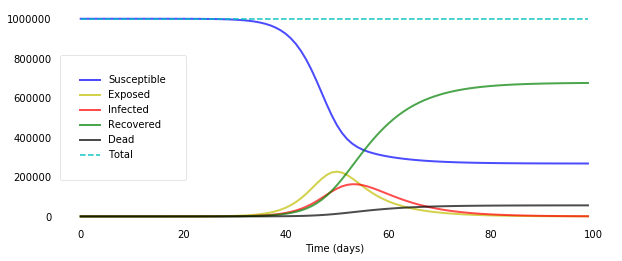

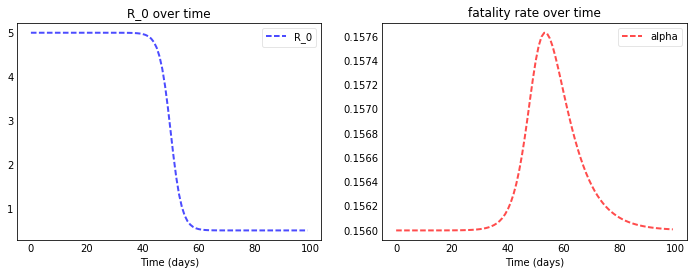

In [28]:
plotseird(t, S, E, I, R, D, R0=R0_over_time, Alpha=Alpha_over_time)